In [1]:
import tensorflow as tf
 
 
 
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import imageio
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from numpy.random import randn
from numpy.random import randint
import tensorflow as tf
print(tf.__version__)

2.2.0


In [3]:
n_images = 12000
batch_size = 128
latent_dim = 100
n_epoch = 100
img_shape = (128, 128, 3)

In [4]:
data_dir = 'img_align_celeba/img_align_celeba' 
images = os.listdir(data_dir)
images = images[:n_images]

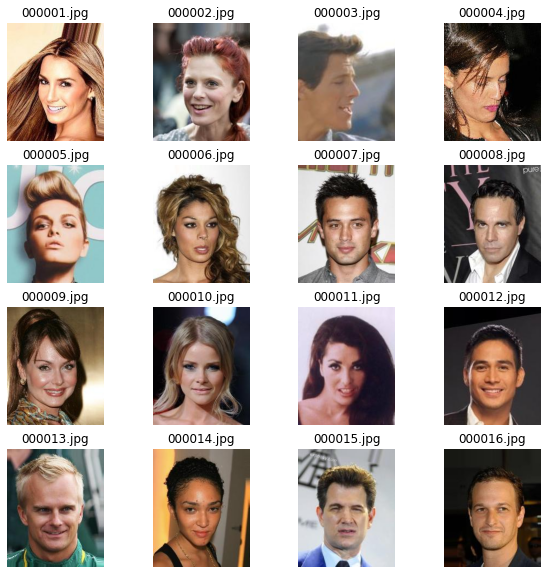

In [5]:
plt.figure(figsize=(10,10))
for i, name in enumerate(images[:16]):
    plt.subplot(4, 4, i + 1)
    img = plt.imread(data_dir + '/' + name)
    plt.imshow(img)
    plt.title(name)
    plt.axis('off')

In [6]:
def get_data(data_path) :
    X = []
    for filename in data_path :
        img = img_to_array(load_img(data_dir + "/" + filename, target_size = img_shape[:2]))
        X.append(img)
    X = np.array(X).astype('float32')
    #X = (X - 127.5) / 127.5
    X = X / 255
    return X

dataset = get_data(images)

In [7]:
def define_discriminator(in_shape=(128,128,3)):
    model = Sequential()
    # normal
    model.add(Conv2D(128, (5,5), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 64x64
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 32x32
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 16x16
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 8x8
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [8]:
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 8x8 feature maps
    n_nodes = 128 * 8 * 8
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((8, 8, 128)))
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 64x64
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 128x128
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # output layer 128x128x3
    model.add(Conv2D(3, (5,5), activation='tanh', padding='same'))
    return model

#input of G
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X, y

In [9]:
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# retrive real samples
def get_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # set 'real' class labels (1)
    y = np.ones((n_samples, 1))
    return X, y

# create and save a plot of generated images
def show_generated(generated,epoch, n=5):
    #[-1,1] -> [0,1] 
    #generated = (generated + 1)/ 2
    #generated = (generated[:n*n] * 127.5) + 127.5
    #generated = generated * 255
    plt.figure(figsize=(10,10))
    for i in range(n * n):
        plt.subplot(n, n, i + 1)
        #img = plt.imread(data_dir + '/' + name)
        plt.imshow(generated[i])
        #plt.title(name)
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch+1))
    plt.show()    

# evaluate the discriminator and plot generated images
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = get_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy [real: %.0f%%, fake: %.0f%%]' % (acc_real*100, acc_fake*100))
    # show plot
    show_generated(x_fake, epoch)

In [10]:
def train(g_model, d_model, gan_model, dataset, latent_dim=100, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    start = time.time()
    for i in range(n_epochs):
        
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = get_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
        print('Epoch: %d,  Loss: D_real = %.3f, D_fake = %.3f,  G = %.3f' %   (i+1, d_loss1, d_loss2, g_loss))
        # evaluate the model performance
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)     
    print ('Total time for training {} epochs is {} sec'.format(n_epochs, (time.time()-start)))

In [11]:
discriminator = define_discriminator()
generator = define_generator(latent_dim)

# create the gan
gan = define_gan(generator, discriminator)

# train model
train(generator, discriminator, gan, dataset, latent_dim, n_epoch, batch_size)

## TODO: Get better output images!

ResourceExhaustedError:  OOM when allocating tensor with shape[128,128,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_2/sequential/conv2d/BiasAdd-0-1-TransposeNCHWToNHWC-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_2783]

Function call stack:
train_function


In [ ]:
files = []
n_iter = int(n_epoch / 10 -1)
for e in range(n_iter):
    img_name = '../working/image_at_epoch_{:04d}.png'.format((e+1)*10)
    files.append(imageio.imread(img_name))
imageio.mimsave('dcgan_celebA_generation_animation.gif', files, fps=5)